# Based off the deep learning notebook, we now test feature importance here.
All the settings are based on the best model from the deep learning notebook.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
working_dataset = pd.read_pickle('working_dataset.pkl')

grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']

categorical_columns = ['Year', 'Term', 'Subject', 'Sched Type', 'Number', 'Course Title']
max_categories = {
    col: max(working_dataset[col].nunique(), working_dataset[col].nunique())
    for col in categorical_columns
}

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

work_train, work_temp = train_test_split(working_dataset, test_size=(1 - train_ratio), random_state=42)
work_val, work_test = train_test_split(work_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)


# Preparing the data as before

In [3]:
def one_hot_encode_fixed(dataframe, column, max_categories):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    one_hot = encoder.fit_transform(dataframe[[column]])

    padded = np.zeros((len(dataframe), max_categories))
    padded[:, :one_hot.shape[1]] = one_hot
    return padded

def encode_categorical_features(dataframe, categorical_columns, max_categories):
    one_hot_encoded = {
        col: one_hot_encode_fixed(dataframe, col, max_categories[col])
        for col in categorical_columns
    }
    return one_hot_encoded

work_train_encoded = encode_categorical_features(work_train, categorical_columns, max_categories)
work_val_encoded = encode_categorical_features(work_val, categorical_columns, max_categories)
work_test_encoded = encode_categorical_features(work_test, categorical_columns, max_categories)

class GradeDataset(Dataset):
    def __init__(self, encoded_features, grade_columns, targets_dataframe):
        self.encoded_features = {col: torch.tensor(encoded_features[col], dtype=torch.float32) for col in encoded_features}
        self.targets = torch.tensor(targets_dataframe[grade_columns].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        features = {col: self.encoded_features[col][idx] for col in self.encoded_features if col != 'Course Title'}
        return features, self.targets[idx]

work_train_dataset = GradeDataset(work_train_encoded, grade_columns, work_train)
work_val_dataset = GradeDataset(work_val_encoded, grade_columns, work_val)
work_test_dataset = GradeDataset(work_test_encoded, grade_columns, work_test)

work_train_loader = DataLoader(work_train_dataset, batch_size=64, shuffle=True)
work_val_loader = DataLoader(work_val_dataset, batch_size=64, shuffle=False)
work_test_loader = DataLoader(work_test_dataset, batch_size=64, shuffle=False)


# model implementation from the deep learning notebook

In [5]:
class ModifiedGradePredictor(nn.Module):
    def __init__(self, feature_sizes, output_dim, dropout_rate, hidden_size):
        super().__init__()
        self.feature_layers = nn.ModuleDict({
            col: nn.Sequential(
                nn.Linear(size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            for col, size in feature_sizes.items()
        })
        self.fc = nn.Sequential(
            nn.Linear(len(feature_sizes) * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_dim)
        )

    def forward(self, features):
        feature_outputs = [layer(features[col]) for col, layer in self.feature_layers.items()]
        combined = torch.cat(feature_outputs, dim=1)
        return F.softmax(self.fc(combined), dim=1)


# Setting up the best hyper params and model and opt call from the deep learning notebook

In [6]:
feature_sizes = {col: max_categories[col] for col in categorical_columns if col != 'Course Title'}
output_dim = len(grade_columns)
dropout = 0.5
hidden_size = 256
weight_decay = 0
patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedGradePredictor(feature_sizes, output_dim, dropout, hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=weight_decay)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=0.5)


# model training---with 10 epochs, as we found it's sufficient to train the model

In [7]:
# Training loop
model.train()
for epoch in range(10):
    train_loss = 0.0
    for features, targets in work_train_loader:
        features = {col: features[col].to(device) for col in features}
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(work_train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

Epoch 1, Train Loss: 0.0111
Epoch 2, Train Loss: 0.0087
Epoch 3, Train Loss: 0.0085
Epoch 4, Train Loss: 0.0083
Epoch 5, Train Loss: 0.0082
Epoch 6, Train Loss: 0.0081
Epoch 7, Train Loss: 0.0080
Epoch 8, Train Loss: 0.0079
Epoch 9, Train Loss: 0.0078
Epoch 10, Train Loss: 0.0077


# feature importance with permutation after the lecture
### here, we randomly shuffle features, one at a time, in order to analyze the impact that the features would bring to the model prediction.

In [8]:
def calculate_feature_importance(model, data_loader, criterion, device, feature_sizes):
    model.eval()
    baseline_loss = 0.0
    with torch.no_grad():
        for features, targets in data_loader:
            features = {col: features[col].to(device) for col in features}
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            baseline_loss += loss.item()
    baseline_loss /= len(data_loader)

    feature_importance = {}
    for col in feature_sizes:
        shuffled_loss = 0.0
        for features, targets in data_loader:
            features = {col_: features[col_].to(device) for col_ in features}
            shuffled_features = features[col].clone()
            shuffled_features = shuffled_features[torch.randperm(shuffled_features.size(0))]
            features[col] = shuffled_features.to(device)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            shuffled_loss += loss.item()
        shuffled_loss /= len(data_loader)
        importance = shuffled_loss - baseline_loss
        feature_importance[col] = importance

    return feature_importance

feature_importance = calculate_feature_importance(
    model=model,
    data_loader=work_val_loader,
    criterion=criterion,
    device=device,
    feature_sizes=feature_sizes
)


In [13]:
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance :")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.8f}")


Feature Importance :
Year: 0.00028574
Number: 0.00005690
Sched Type: 0.00003366
Term: 0.00001003
Subject: -0.00009799


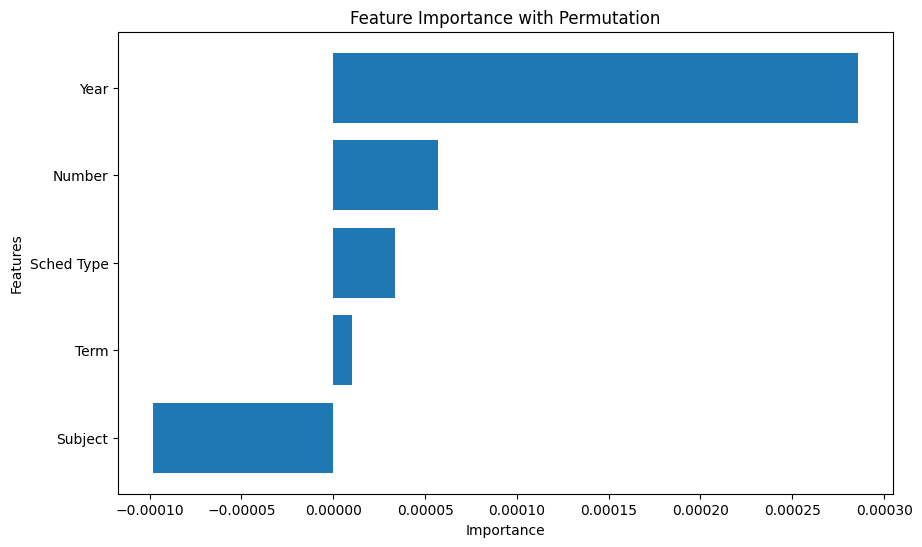

In [11]:
# Plot feature importance
features, importances = zip(*sorted_importance)
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance with Permutation')
plt.gca().invert_yaxis()
plt.show()

# Feature important analysis with permutation
### From the feature importance analysis with permutation on each feature, it shows the impact scale is in the following order: Year > Number > Schedule Type > Term > Subject.
It shows that the feature, Year, shows the most impact, which can be somewhat expected as there has been a huge average grade inflation (EDA notebook). Therefore, it indicates that knowing Year is important in model prediction since it helps the model determine the average grades that serve as the baseline for each grade distribution prediction.

Then, it shows that the feature Number is the second most important impact factor for the model prediction. It can also be a reasonable impact since, examplifying the engineering classes, the introductory(lower-division) classes are usually located on 100-200 in course number, and 300-400 for the upper-division undergraduate level and then higher for graduate level courses. Different department has different scheme in allocation of course numbers, but it should affect the model prediction along with the information from other features.

Then, there are features with relatively little impact, such as Schedule Type and Term. Surprisingly, the feature Subject shows negative value, which indicates that shuffling the values from the feature Subject would improve the model prediction performance. We can infer two reasonings from the analysis--higher model complexity and overfitting.

The number of unique values in the feature Subject is 172. From the feature importance analysis, it would indicate that it brings uncessary complexity to the model for training and fitting to the training dataset, which can result in overfitting to the dataset. As we used one-hot encoding to represent the feature Subject, it is possible that we introduce the model to the unnecesarily high dimension to deal with.

# For the next, we analyze the feature important with Shapley Values on subject of dataset

In [20]:
import shap

shap_data, shap_targets = next(iter(work_val_loader))
shap_features = {col: shap_data[col].to(device) for col in shap_data}

## designed a wrapper for transitioning from pytorch model to shapley value library

In [21]:
class SHAPWrapper:
    def __init__(self, model, feature_sizes):
        self.model = model
        self.feature_sizes = feature_sizes

    def __call__(self, inputs):
        start_idx = 0
        features = {}
        for col, size in self.feature_sizes.items():
            end_idx = start_idx + size
            features[col] = torch.tensor(inputs[:, start_idx:end_idx], dtype=torch.float32).to(device)
            start_idx = end_idx

        with torch.no_grad():
            outputs = self.model(features)
        return outputs.cpu().numpy()

## computing the Shapley values

In [22]:
shap_inputs = np.concatenate([shap_features[col].cpu().numpy() for col in shap_features], axis=1)

shap_model = SHAPWrapper(model, feature_sizes)

explainer = shap.KernelExplainer(shap_model, shap_inputs)
shap_values = explainer.shap_values(shap_inputs[:100])

  0%|          | 0/64 [00:00<?, ?it/s]

## as the model predicts the grade distribution ( model prediction is of 14 grades), we plot out the Shapley value plot for each grade

Processing SHAP values for output index 0...


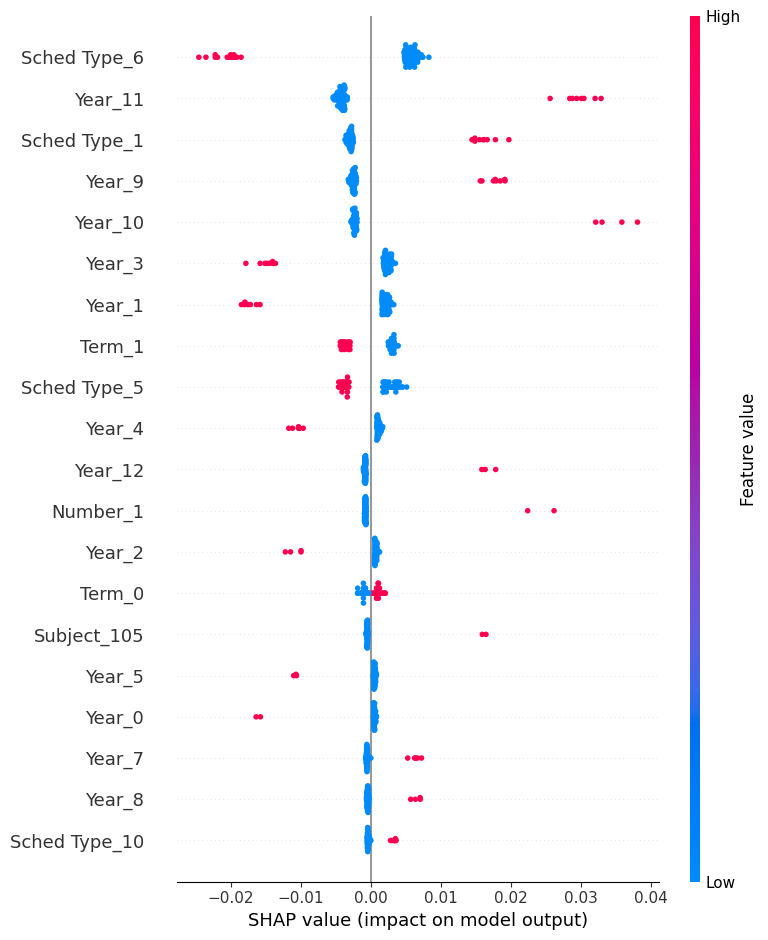

Completed SHAP analysis for output index 0.
Processing SHAP values for output index 1...


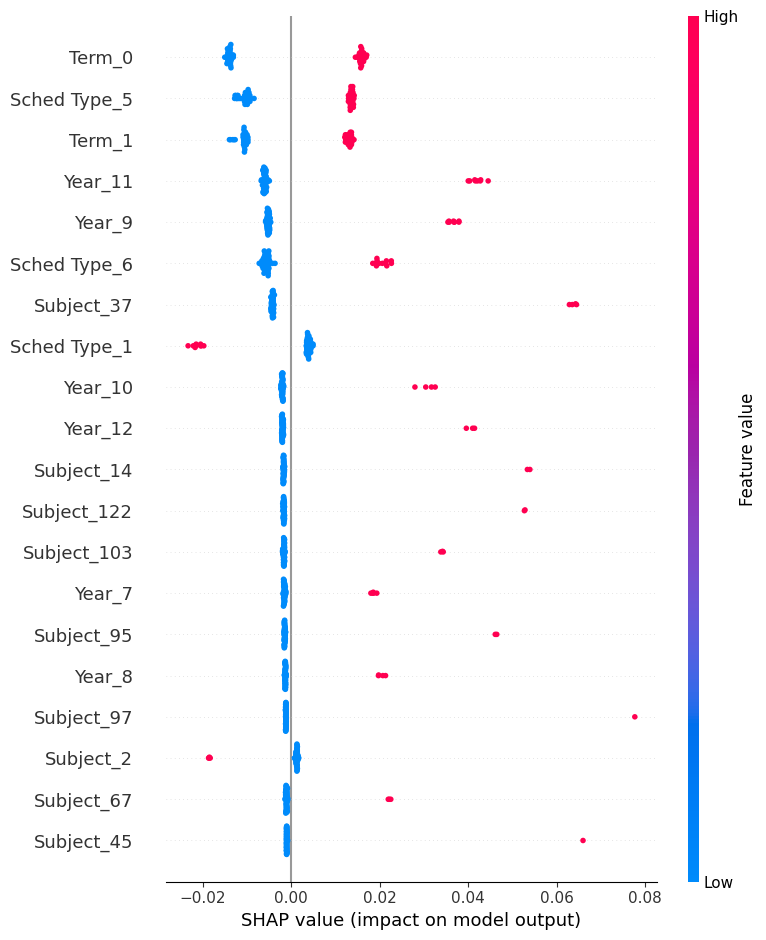

Completed SHAP analysis for output index 1.
Processing SHAP values for output index 2...


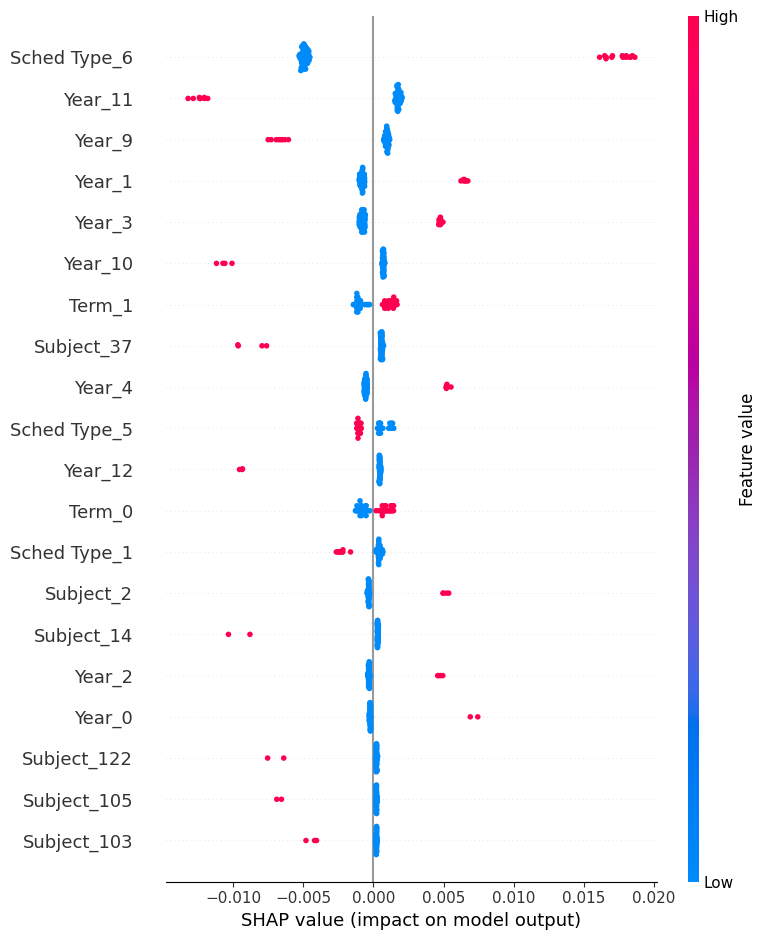

Completed SHAP analysis for output index 2.
Processing SHAP values for output index 3...


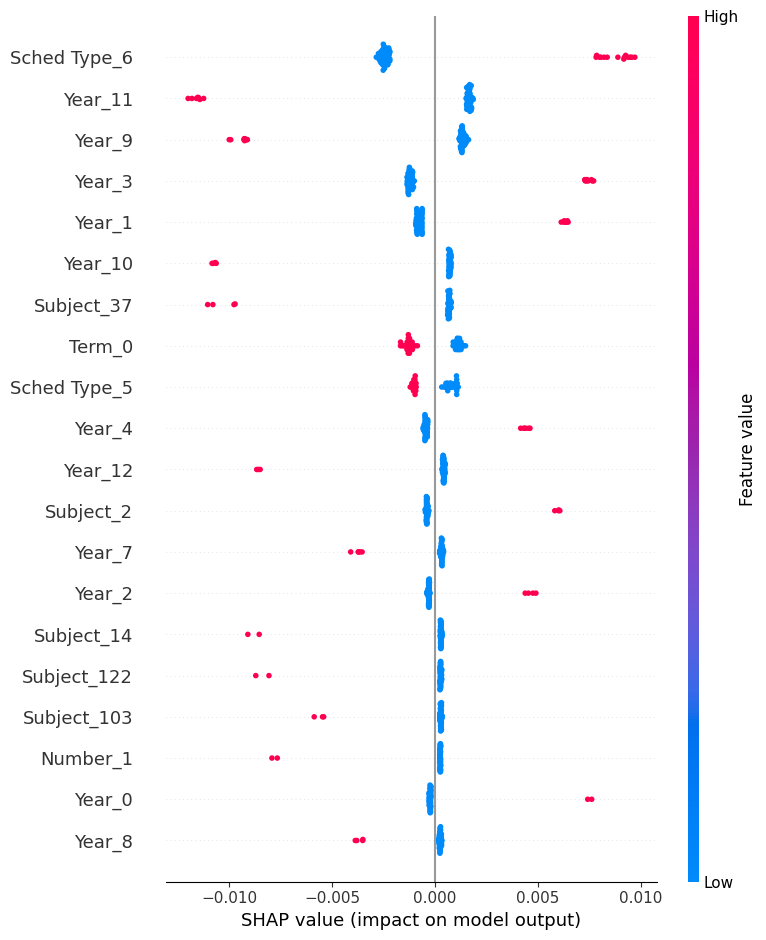

Completed SHAP analysis for output index 3.
Processing SHAP values for output index 4...


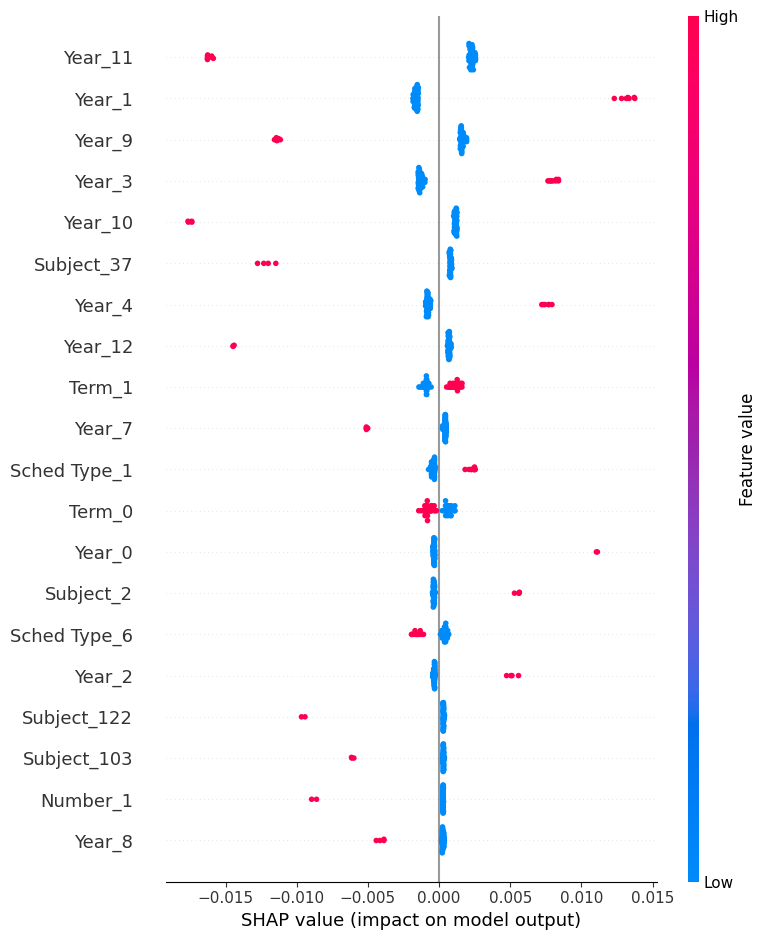

Completed SHAP analysis for output index 4.
Processing SHAP values for output index 5...


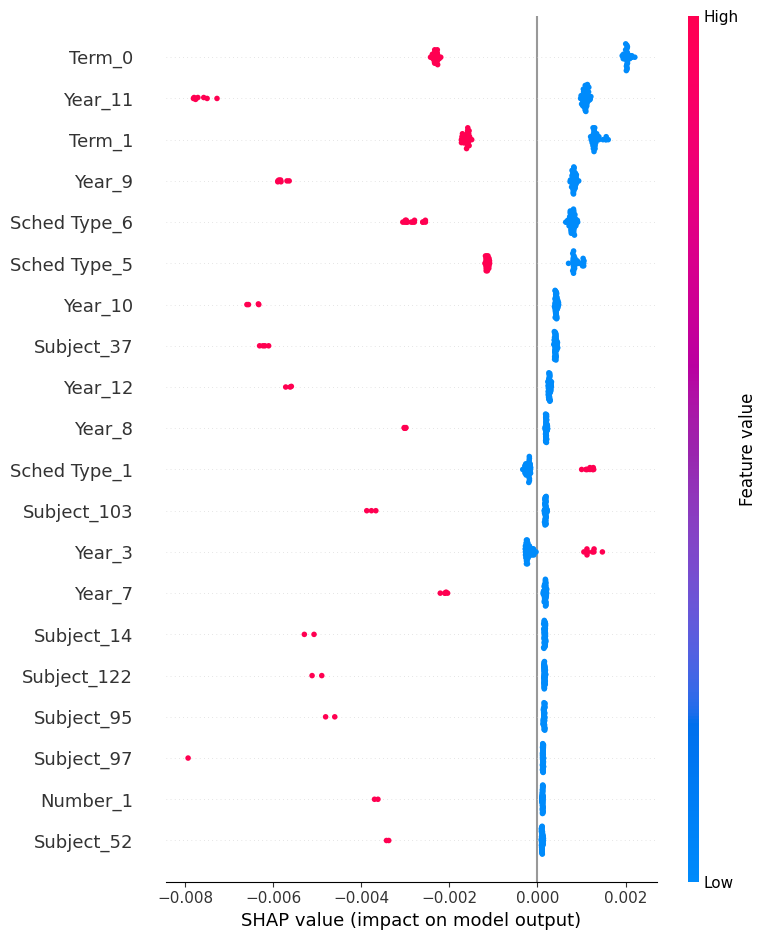

Completed SHAP analysis for output index 5.
Processing SHAP values for output index 6...


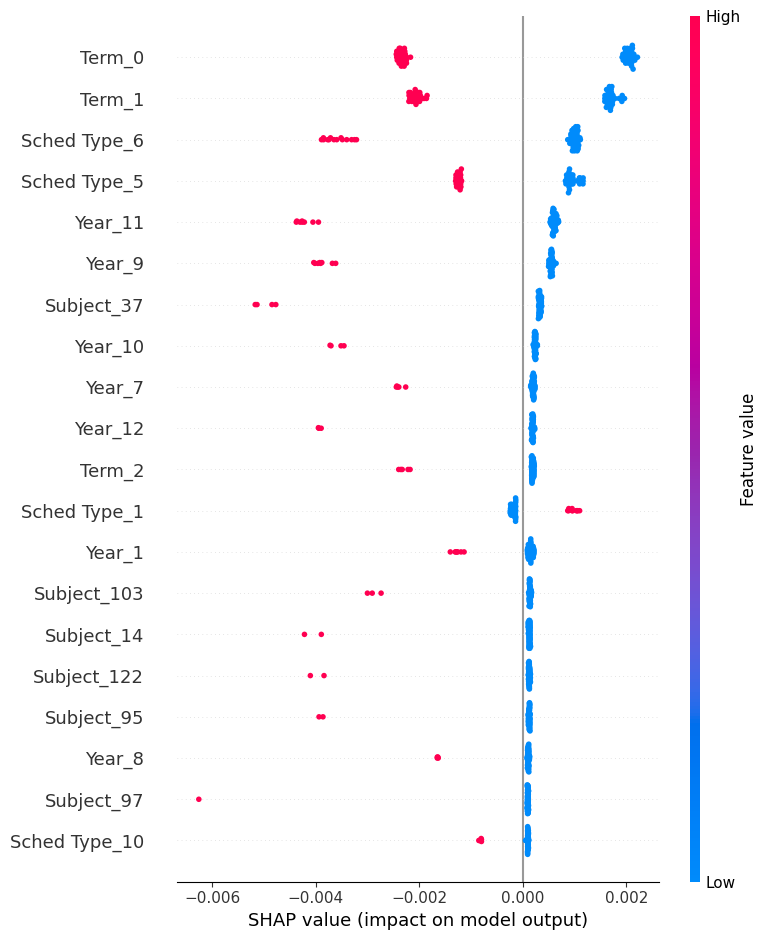

Completed SHAP analysis for output index 6.
Processing SHAP values for output index 7...


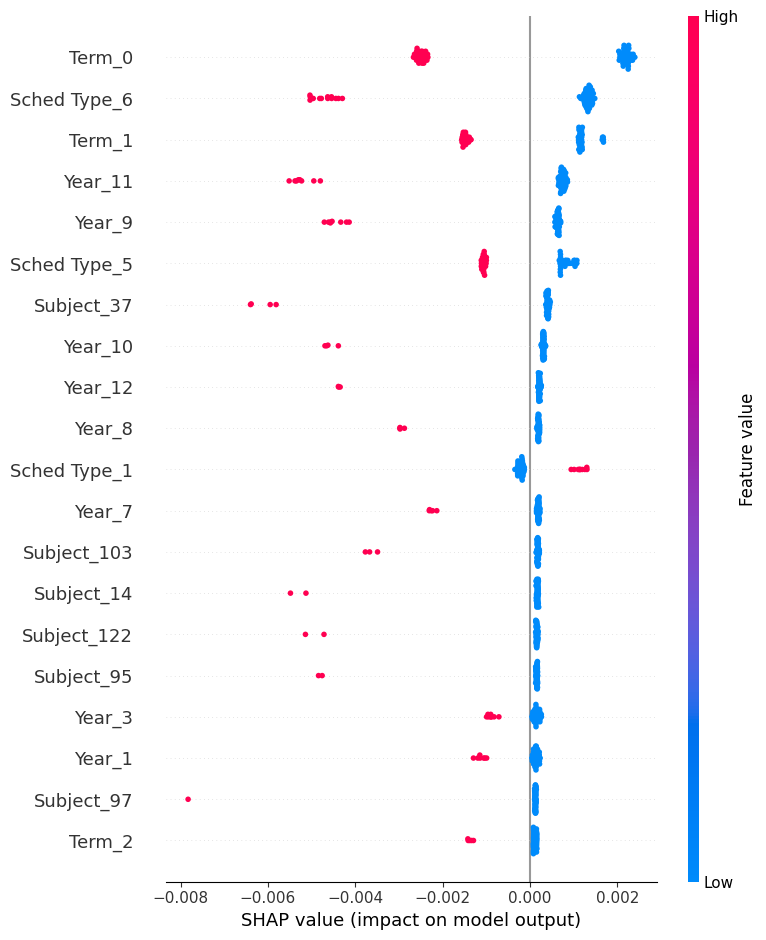

Completed SHAP analysis for output index 7.
Processing SHAP values for output index 8...


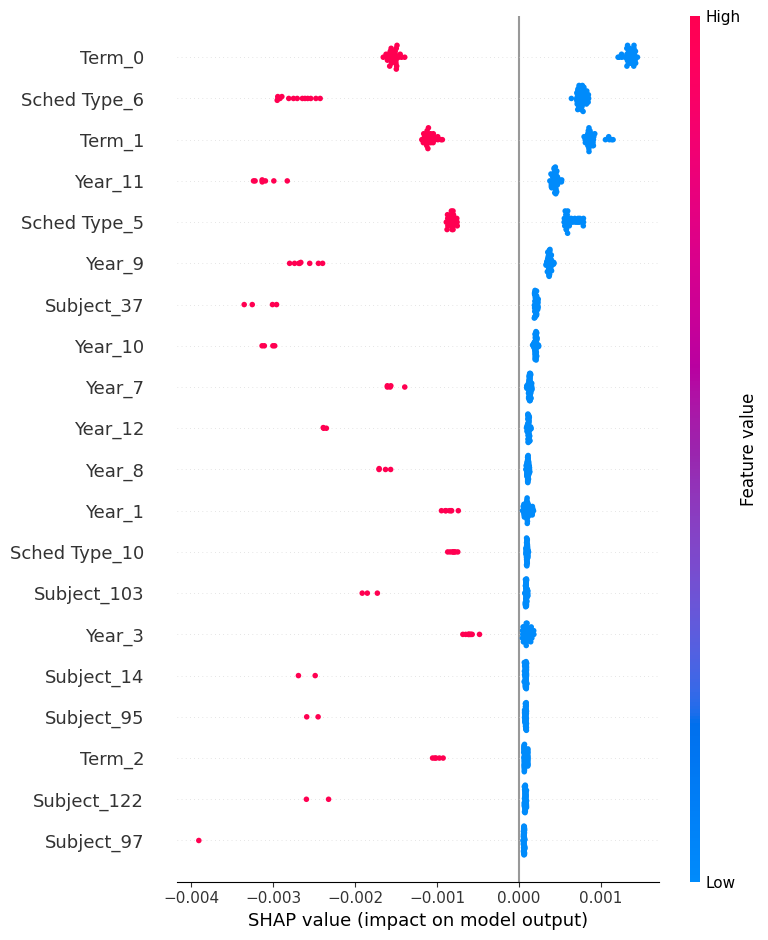

Completed SHAP analysis for output index 8.
Processing SHAP values for output index 9...


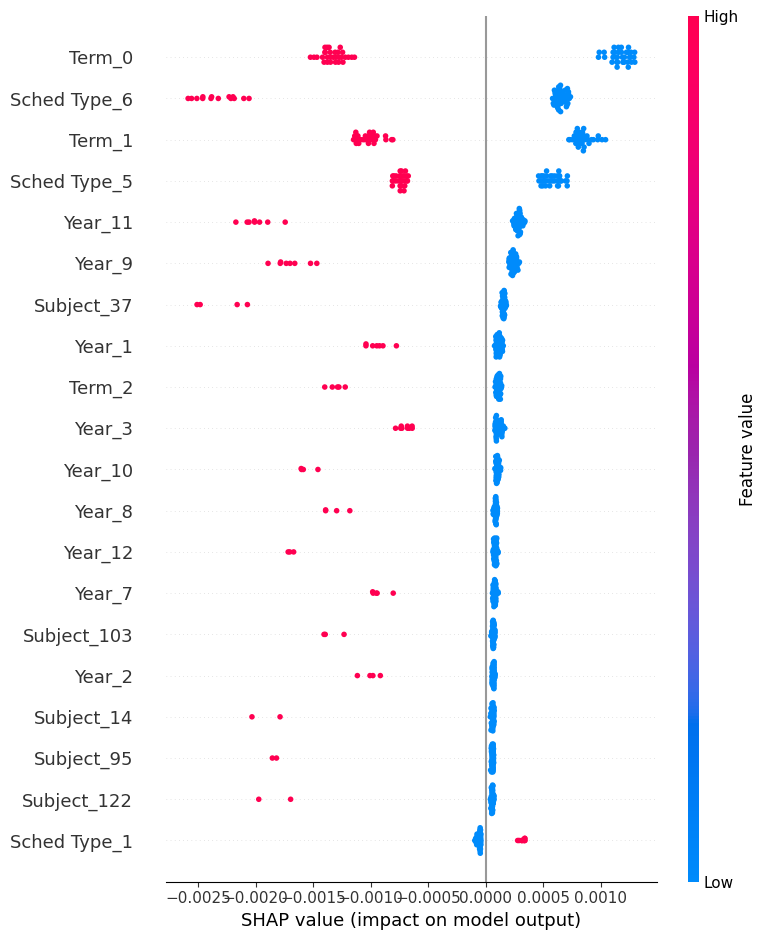

Completed SHAP analysis for output index 9.
Processing SHAP values for output index 10...


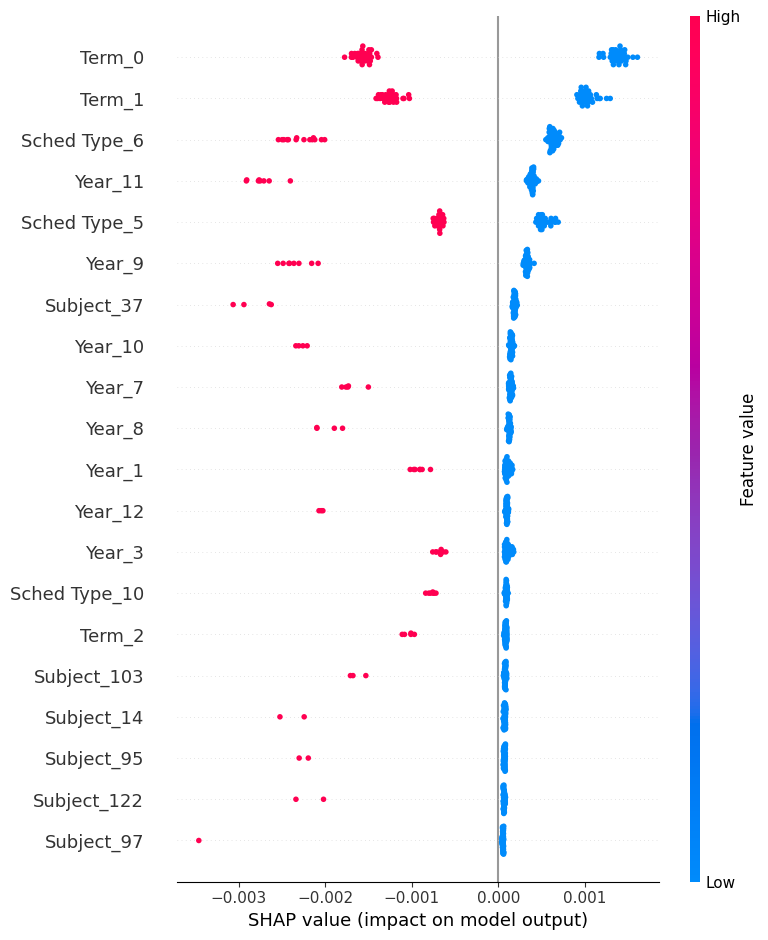

Completed SHAP analysis for output index 10.
Processing SHAP values for output index 11...


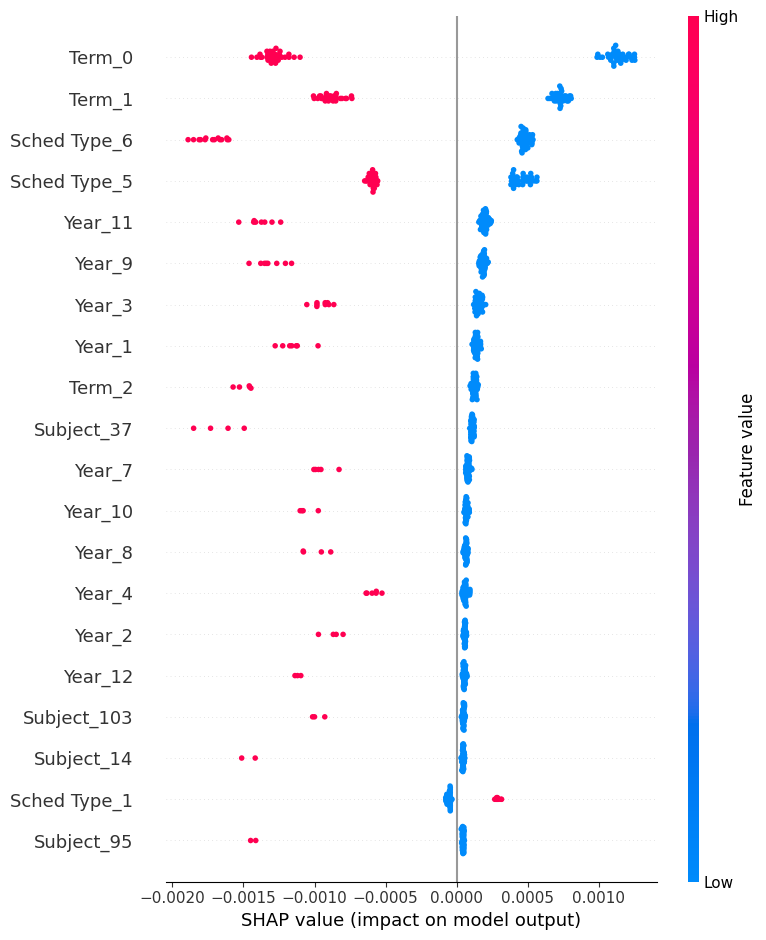

Completed SHAP analysis for output index 11.
Processing SHAP values for output index 12...


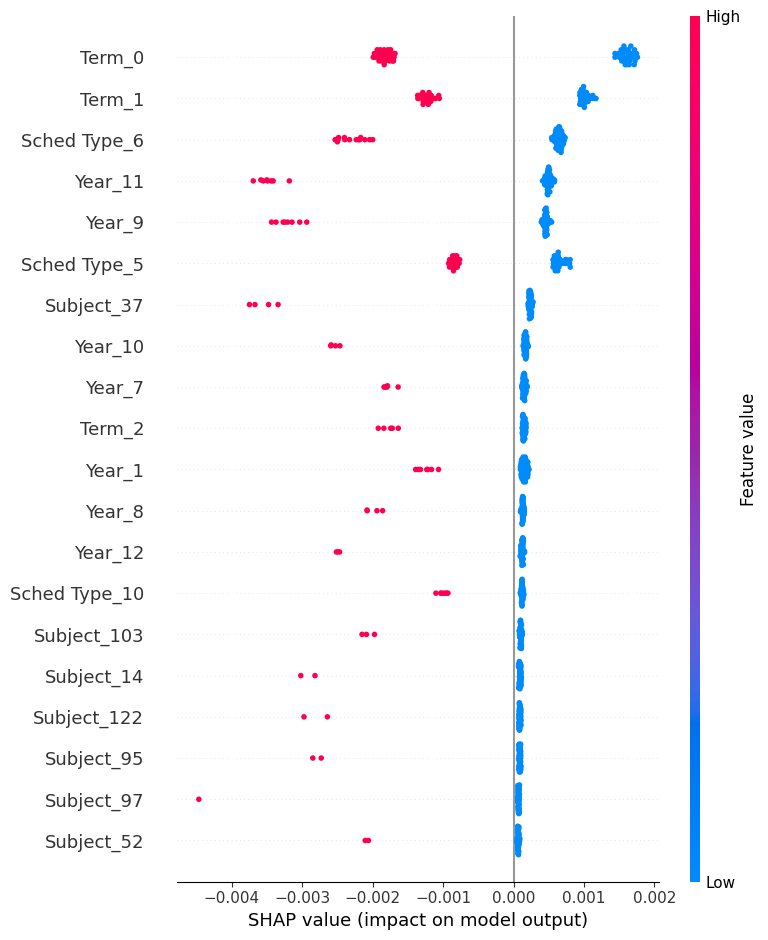

Completed SHAP analysis for output index 12.
Processing SHAP values for output index 13...


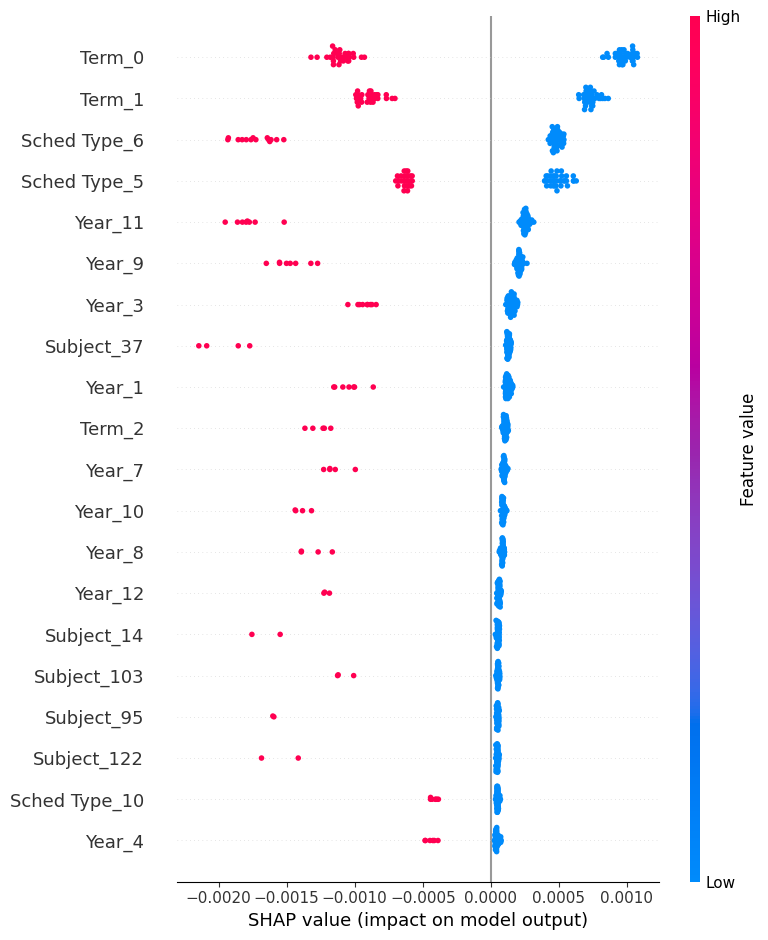

Completed SHAP analysis for output index 13.


In [31]:
expanded_feature_names = []
for col, size in feature_sizes.items():
    expanded_feature_names.extend([f"{col}_{i}" for i in range(size)])

# Loop through each grade
for output_index in range(shap_values.shape[2]):  # 14 grades
    print(f"Processing SHAP values for output index {output_index}...")

    shap_values_single_output = shap_values[:, :, output_index]  #(64, 760)


    #SHAP summary plot
    shap.summary_plot(
        shap_values_single_output,
        shap_inputs[:100],
        feature_names=expanded_feature_names,
        show=True
    )
    print(f"Completed SHAP analysis for output index {output_index}.")



## Feature Important with Shapley Value
Since the analysis is performed only on a small subset of the dataset, it is possible that it could bring the limited interpretation. However, throughout the shapley value plots, we can notice that specific features always appear as the import important factors, such as Schedule Type 1, 6, Year 9, 10, 11, and Term 0. Addiontionally, it constantly shows that the most of the top most important features appear to be Year, and thus it aligns with the inference from the feature imporatnt analysis with permutation.